#!/usr/bin/env python3

In [41]:
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.color_palette('Spectral')
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from lineage import Lineage
import imutils
from imutils.video import FPS
import cv2
import tensorflow as tf
from PIL import Image

In [42]:
data = pd.read_csv('genomee.txt', sep='\t', dtype={'rsid':'str', 'chromosome':'object', 'position':'int', 'genotype':'str'}, comment='#')

In [43]:
print(data)

               rsid chromosome  position genotype
0       rs548049170          1     69869       TT
1        rs13328684          1     74792       --
2         rs9283150          1    565508       AA
3           i713426          1    726912       AA
4       rs116587930          1    727841       GG
...             ...        ...       ...      ...
638542     i4000693         MT     16524        A
638543      i704756         MT     16524        A
638544      i705255         MT     16525        A
638545     i4000757         MT     16526        G
638546      i701671         MT     16526        G

[638547 rows x 4 columns]


In [44]:
df = pd.DataFrame(data)

In [45]:
df.head(25)

rsid chromosome  position genotype
0   rs548049170          1     69869       TT
1    rs13328684          1     74792       --
2     rs9283150          1    565508       AA
3       i713426          1    726912       AA
4   rs116587930          1    727841       GG
5     rs3131972          1    752721       AG
6    rs12184325          1    754105       CC
7    rs12567639          1    756268       AA
8   rs114525117          1    759036       GG
9    rs12124819          1    776546       --
10   rs12127425          1    794332       GG
11   rs79373928          1    801536       TT
12   rs72888853          1    815421       --
13    rs7538305          1    824398       AA
14   rs28444699          1    830181       AA
15      i713449          1    830731       --
16  rs116452738          1    834830       GG
17   rs72631887          1    835092       TT
18   rs28678693          1    838665       TT
19    rs4970382          1    840753       TT
20    rs4475691          1    846808       CT
21   rs72631889          1    851390       GG
22    rs7537756          1    854250       GG
23   rs13302982          1    861808       AA
24  rs376747791          1    863130       AA

In [46]:
df.nunique()

 rsid         638547
chromosome        25
position      634977
genotype          20
dtype: int64

In [47]:
duplicates = df[df.duplicated(subset='position')]
display(duplicates.head())
display(duplicates.info())

rsid chromosome  position genotype
449   i6059967          1   2526746       GG
2816  i6052145          1  11009679       GG
5325  i6012699          1  19992513       CC
5339  i6059797          1  20020994       CT
5791  i6058167          1  21795388       AA

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3570 entries, 449 to 638546
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0    rsid       3570 non-null   object
 1   chromosome  3570 non-null   object
 2   position    3570 non-null   int64 
 3   genotype    3570 non-null   object
dtypes: int64(1), object(3)
memory usage: 139.5+ KB


None

In [48]:
df = df[df.chromosome != 'Y']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634814 entries, 0 to 638546
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0    rsid       634814 non-null  object
 1   chromosome  634814 non-null  object
 2   position    634814 non-null  int64 
 3   genotype    634814 non-null  object
dtypes: int64(1), object(3)
memory usage: 24.2+ MB


In [49]:
df['chromosome'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X',
       'MT'], dtype=object)

In [50]:
df['chromosome'] = df['chromosome'].apply(lambda x: re.sub(r'X', r'23', x))
df['chromosome'] = df['chromosome'].apply(lambda x: re.sub(r'MT', r'24', x))

In [51]:
df['chromosome'] = df['chromosome'].apply(lambda x: int(x))

In [52]:
chromosome_dict = {1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'10', 11:'11', 12:'12', 13:'13', 
                  14:'14', 15:'15', 16:'16', 17:'17', 18:'18', 19:'19', 20:'20', 21:'21', 22:'22', 23:'X', 24:'MT'}

In [53]:
print(chromosome_dict)
df.info()

{1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: 'X', 24: 'MT'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 634814 entries, 0 to 638546
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0    rsid       634814 non-null  object
 1   chromosome  634814 non-null  int64 
 2   position    634814 non-null  int64 
 3   genotype    634814 non-null  object
dtypes: int64(2), object(2)
memory usage: 24.2+ MB


In [54]:
genotype_na = df[df.genotype == '--']
len(genotype_na)

16733

In [55]:
df[df.chromosome == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49516 entries, 0 to 49515
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0    rsid       49516 non-null  object
 1   chromosome  49516 non-null  int64 
 2   position    49516 non-null  int64 
 3   genotype    49516 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


In [56]:
df.rename({' rsid': 'rsid'}, axis='columns', inplace=True)

In [57]:
rsid_per_chromosome_series = df.groupby('chromosome')['rsid'].count()
rsid_per_chromosome_series.columns = ['chromosome', 'count']

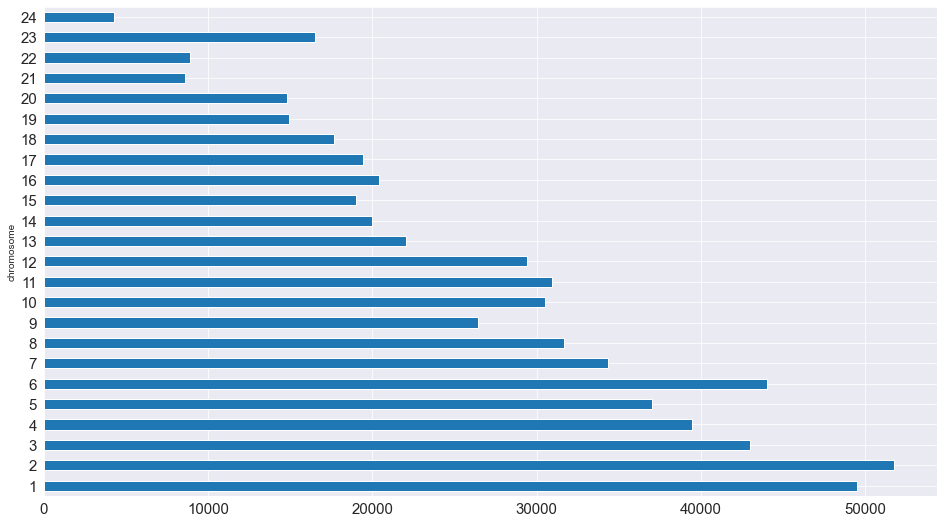

<Figure size 432x288 with 0 Axes>

In [58]:
rsid_per_chromosome_series.plot.barh(figsize=(16,9), fontsize=15)
plt.show()
plt.savefig("counts.png")

In [59]:
snp_df = pd.read_csv('result.csv')
snp_df.head(50)

Unnamed: 0  Magnitude  \
0    Rs1801253(G;G)        0.0   
1   Rs17822931(T;T)        2.5   
2   Rs16891982(C;C)        1.1   
3     Rs351855(C;C)        0.0   
4     Rs713598(C;C)        1.1   
5    Rs1726866(C;C)        0.1   
6    Rs2227564(T;T)        0.0   
7       Rs4680(G;G)        2.5   
8       Rs4680(A;A)        2.5   
9    Rs2476601(G;G)        0.0   
10   Rs3135506(G;G)        0.0   
11      Rs6265(G;G)        0.0   
12   Rs3816873(T;T)        0.0   
13   Rs3816873(C;C)        2.2   
14   Rs3948464(T;T)        0.0   
15    Rs696217(G;G)        0.0   
16    Rs800292(T;T)        2.0   
17  Rs11556045(A;A)        0.0   
18  Rs11556045(G;G)        0.0   
19   Rs1800450(G;G)        0.0   
20   Rs1801270(C;C)        0.0   
21    Rs709932(G;G)        0.0   
22   Rs1045485(G;G)        0.0   
23   Rs1045485(C;C)        2.0   
24   Rs1065852(C;C)        0.0   
25    Rs429358(T;T)        0.0   
26     Rs12026(C;C)        0.0   
27   Rs1799864(G;G)        0.0   
28      Rs6025(G;G)        0.0   
29   Rs1061147(A;C)        1.0   
30   Rs4950928(G;C)        2.0   
31   Rs1859962(G;T)        0.0   
32  Rs11556045(A;G)        0.0   
33    Rs713598(C;G)        1.1   
34   Rs6602024(G;G)        0.0   
35    Rs806380(G;G)        2.1   
36    Rs908832(G;G)        0.0   
37   Rs2395029(T;T)        0.0   
38   Rs3810682(G;G)        0.0   
39  Rs28929768(T;T)        0.0   
40  Rs28999110(C;C)        0.0   
41  Rs28999111(C;C)        0.0   
42  Rs28999112(C;C)        0.0   
43  Rs28999114(A;A)        0.0   
44       Rs669(A;A)        0.0   
45       Rs661(G;G)        0.0   
46      Rs6647(T;T)        0.0   
47      Rs6647(C;C)        0.0   
48      Rs1303(T;T)        0.0   
49  Rs28929471(G;G)        0.0   

                                              Summary  
0                                                 NaN  
1   Dry earwax. No body odour. Likely Asian ancest...  
2   generally non-European, but if European, 7x mo...  
3                                              normal  
4                                   Can taste bitter.  
5                                    can taste bitter  
6                                   common in clinvar  
7        (warrior) multiple associations, see details  
8   (worrier) advantage in memory and attention tasks  
9                Normal risk for autoimmune disorders  
10                          common on affy axiom data  
11                                      common/normal  
12                                               None  
13                    reduced risk of type-2 diabetes  
14                                  common in clinvar  
15                                  common in clinvar  
16          5% decreased risk of macular degeneration  
17                                  common in clinvar  
18                                benign polymorphism  
19                                  common in clinvar  
20                                        normal risk  
21                                  common in clinvar  
22                                      common/normal  
23                      Reduced Risk of Breast Cancer  
24                                             normal  
25                                             common  
26                                  common in clinvar  
27                                  common in clinvar  
28                   normal/common risk of thrombosis  
29  Normal 0.97x risk for Age Related Macular Dege...  
30                   Half the risk (maybe) of Asthma.  
31                                        normal risk  
32                                benign polymorphism  
33                                  Can taste bitter.  
34                                             normal  
35       uncommon. lowest odds of cannabis dependence  
36                                             normal  
37                                             common  
38                                             common  
39                                

In [60]:
snp_df['genotype'] = snp_df['Unnamed: 0'].apply(lambda x: re.sub(r'.*([AGCT]);([AGCT])\)', r'\1\2', x))

In [61]:
snp_df.head()

Unnamed: 0  Magnitude  \
0   Rs1801253(G;G)        0.0   
1  Rs17822931(T;T)        2.5   
2  Rs16891982(C;C)        1.1   
3    Rs351855(C;C)        0.0   
4    Rs713598(C;C)        1.1   

                                             Summary genotype  
0                                                NaN       GG  
1  Dry earwax. No body odour. Likely Asian ancest...       TT  
2  generally non-European, but if European, 7x mo...       CC  
3                                             normal       CC  
4                                  Can taste bitter.       CC

In [62]:
new_cols = ['rsid', 'magnitude', 'summary', 'genotype']
snp_df.columns = new_cols

In [63]:
snp_df['rsid'] = snp_df['rsid'].map(lambda x : x.lower())
snp_df['rsid'] = snp_df['rsid'].map(lambda x : re.sub(r'([a-z]{1,}[\d]+)\([agct];[agct]\)', r'\1', x))

In [64]:
snp_df.head()

rsid  magnitude                                            summary  \
0   rs1801253        0.0                                                NaN   
1  rs17822931        2.5  Dry earwax. No body odour. Likely Asian ancest...   
2  rs16891982        1.1  generally non-European, but if European, 7x mo...   
3    rs351855        0.0                                             normal   
4    rs713598        1.1                                  Can taste bitter.   

  genotype  
0       GG  
1       TT  
2       CC  
3       CC  
4       CC

In [65]:
snp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rsid       11000 non-null  object 
 1   magnitude  11000 non-null  float64
 2   summary    10866 non-null  object 
 3   genotype   11000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 343.9+ KB


In [66]:
snp_df.isna().any()

rsid         False
magnitude    False
summary       True
genotype     False
dtype: bool

In [67]:
new_df = snp_df.merge(df, how='inner', on=['rsid', 'genotype'], suffixes=('_SNPedia', '_myDNA'))

In [68]:
new_df.head(1000000)

rsid  magnitude                                            summary  \
0    rs16891982        1.1  generally non-European, but if European, 7x mo...   
1    rs16891982        1.1  generally non-European, but if European, 7x mo...   
2      rs696217        0.0                                  common in clinvar   
3      rs696217        0.0                                  common in clinvar   
4     rs1045485        2.0                      Reduced Risk of Breast Cancer   
..          ...        ...                                                ...   
937   rs1143646        0.0                        common in complete genomics   
938  rs10509680        0.0                          common on affy axiom data   
939    rs789852        0.0                        common in complete genomics   
940   rs7762619        0.0                        common in complete genomics   
941  rs56398830        0.0                        common in complete genomics   

    genotype  chromosome   position  
0         CC           5   33951693  
1         CC           5   33951693  
2         GG           3   10331457  
3         GG           3   10331457  
4         CC           2  202149589  
..       ...         ...        ...  
937       TT           4    3148653  
938       GG          10   96734339  
939       CC           3  194327098  
940       TT           6   31531310  
941       GG          13  103701690  

[942 rows x 6 columns]

In [69]:
genes_to_display = new_df[new_df.magnitude > 2]

In [70]:
genes_to_display.head(50)

rsid  magnitude                                            summary  \
246  rs1815739        2.2        Better performing muscles. Likely sprinter.   
247  rs1815739        2.2        Better performing muscles. Likely sprinter.   
359  rs3129934        2.1           Normal lower risk of Multiple Sclerosis.   
420  rs2070744        2.1                         cardiovascular differences   
424    rs53576        2.5      Optimistic and empathetic; handle stress well   
439  rs1799990        2.1  Resistance to vCJD (PrP 129 Met/Val heterozygo...   

    genotype  chromosome   position  
246       CC          11   66328095  
247       CC          11   66328095  
359       CC           6   32336187  
420       TT           7  150690079  
424       GG           3    8804371  
439       AG          20    4680251

In [71]:
print (genes_to_display.summary.values)

['Better performing muscles. Likely sprinter.'
 'Better performing muscles. Likely sprinter.'
 'Normal lower risk of Multiple Sclerosis.' 'cardiovascular differences'
 'Optimistic and empathetic; handle stress well'
 'Resistance to vCJD (PrP 129 Met/Val heterozygote), 4.6x reduced risk of sporadic CJD and 0.87x reduced risk for late-onset Alzheimer in a Caucasian population']


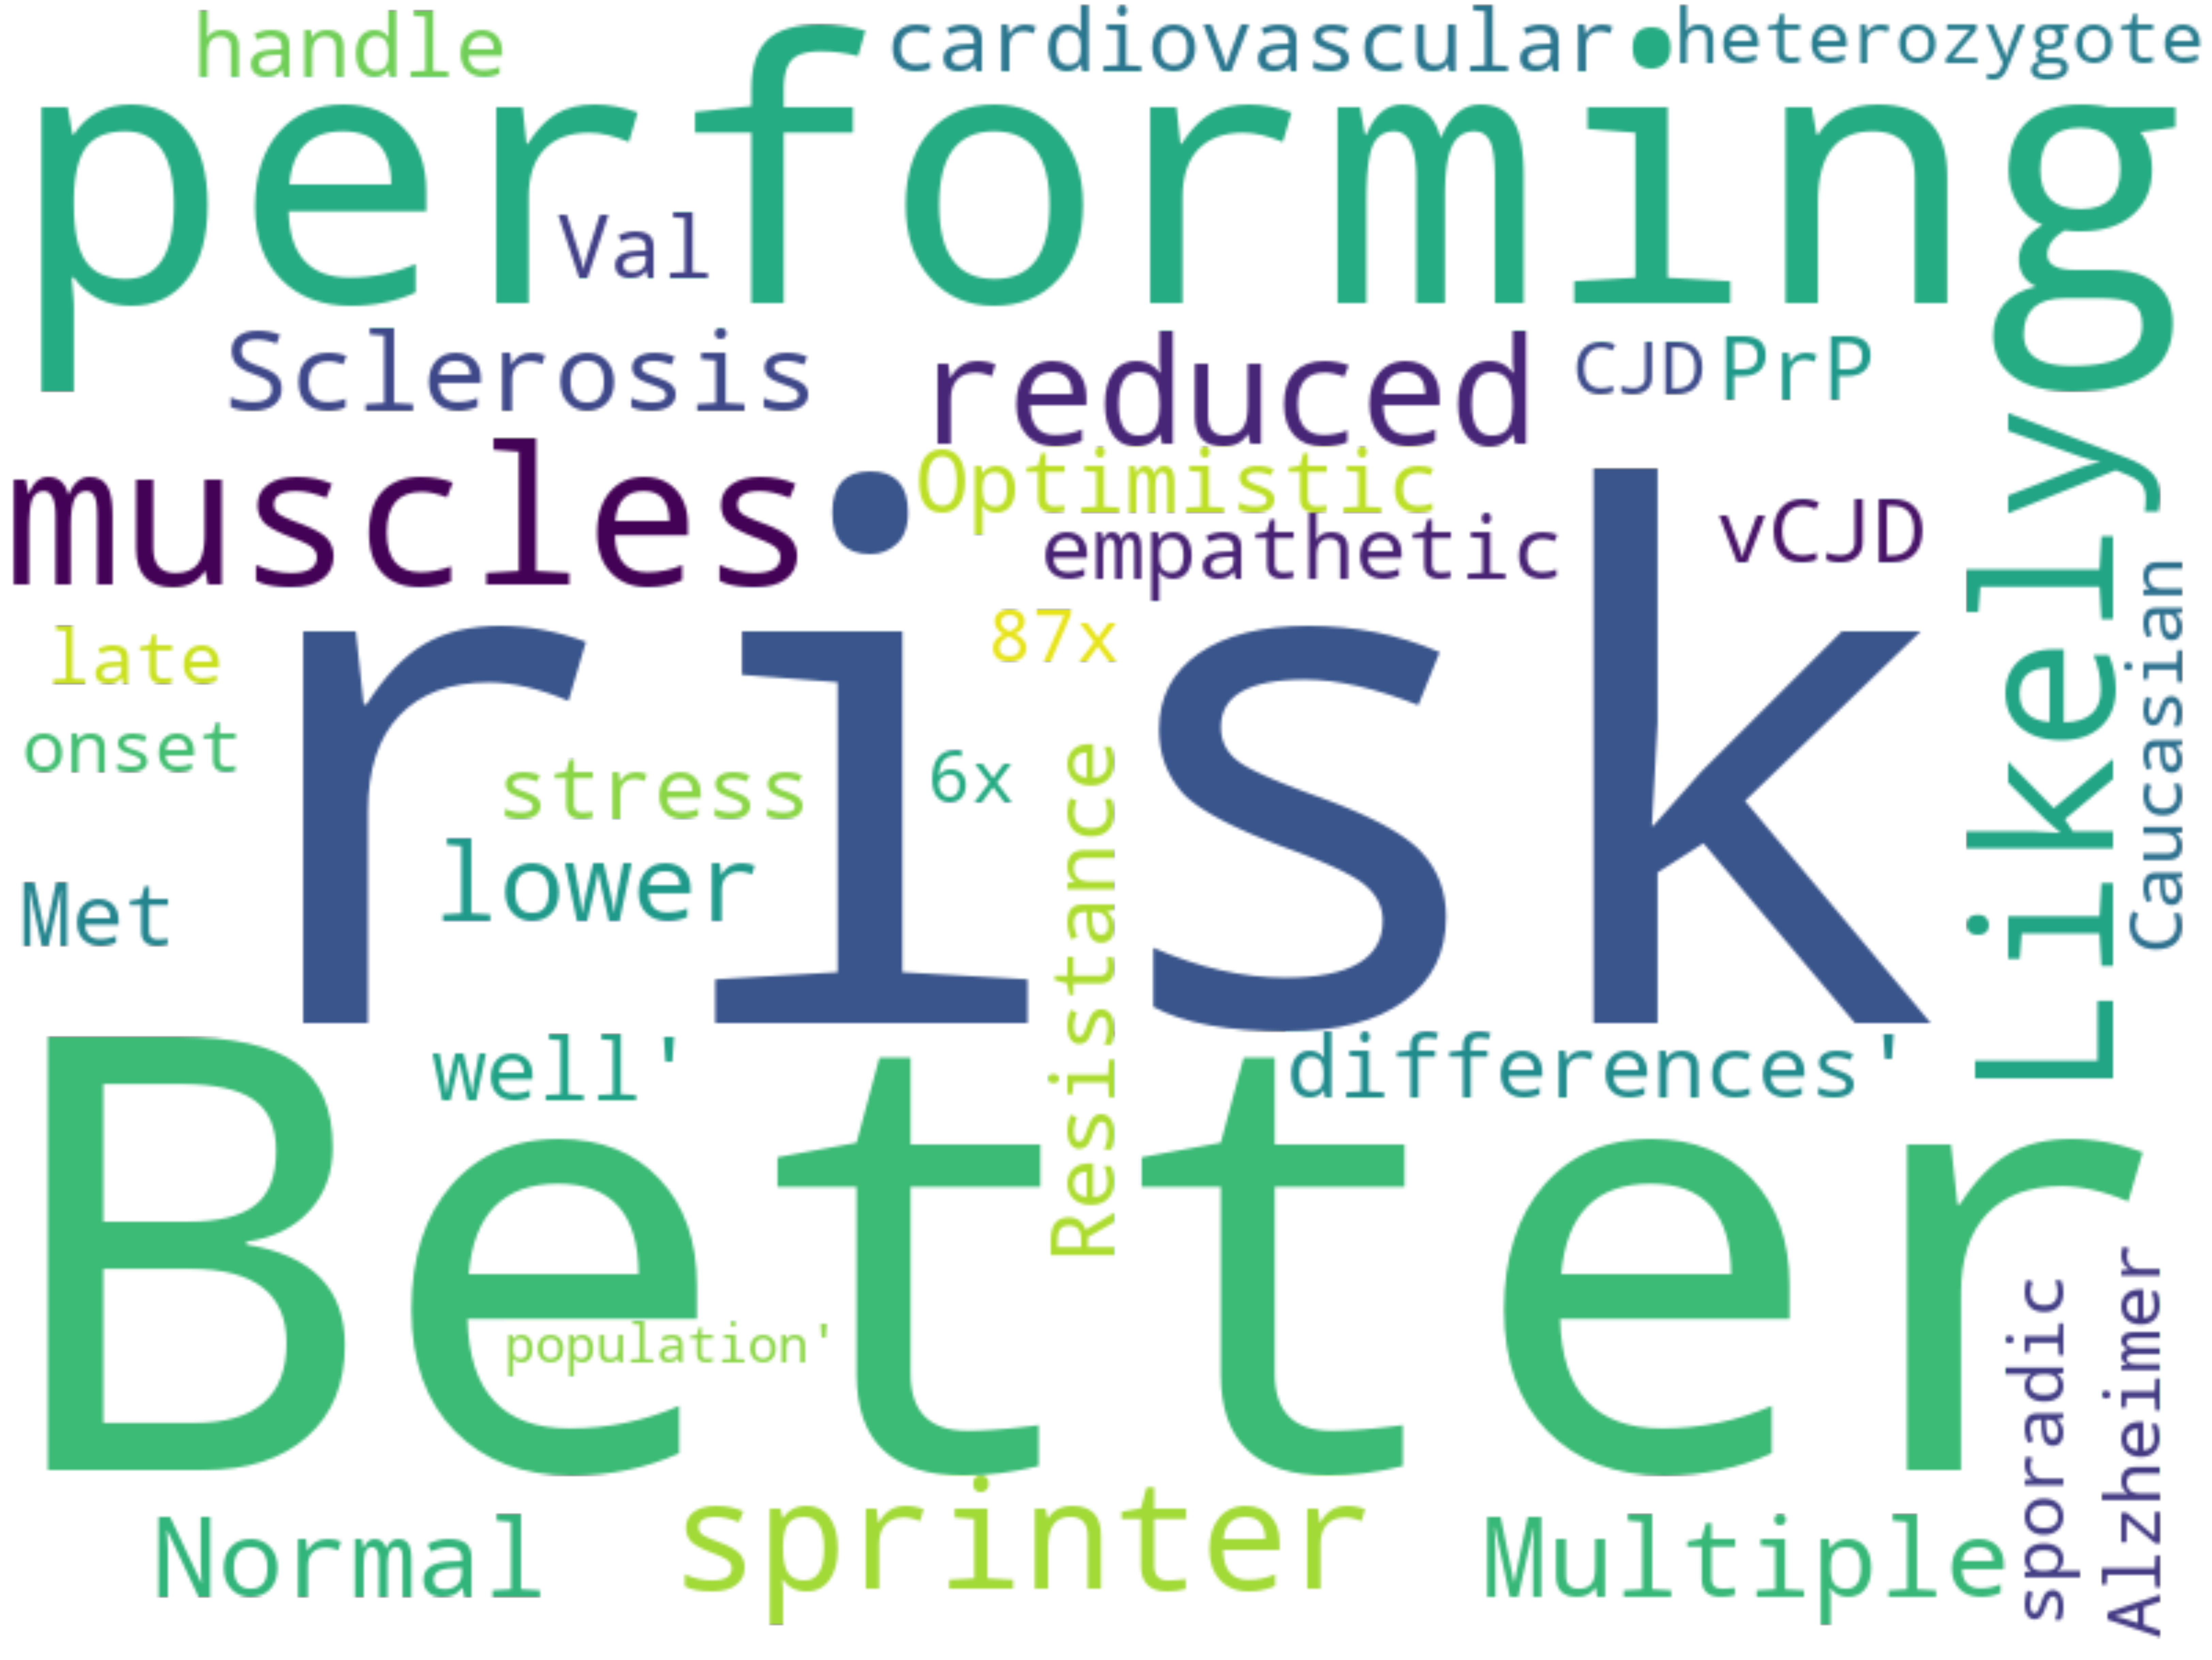

<Figure size 432x288 with 0 Axes>

In [72]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = genes_to_display.summary.values
wordcloud = WordCloud(
    width = 800,
    height = 600,
    mode = 'RGBA',
    background_color = None,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (90, 80),
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig("wordcloud.png")


In [73]:
img = Image.open('wordcloud.png')
img = img.convert("RGBA")

pixdata = img.load()

width, height = img.size
for y in range(height):
    for x in range(width):
        if pixdata[x, y] == (255, 255, 255, 255):
            pixdata[x, y] = (255, 255, 255, 0)

img.save("wordcloud.png", "PNG")

In [75]:
train_data = pd.read_csv(r'training_frames_keypoints.csv')

In [84]:
temp = train_data.to_numpy()
base_dir = '\training'


In [86]:
images['Ben_Stein_51.jpg'].shape


NameError: name 'images' is not defined

In [87]:
from PIL import Image
# making the dataset : 
X = []
Y = []
for i in images.keys():
    # target variable y :
    original_size = images[i].shape
    xe = 112/original_size[0]
    ye = 112/original_size[1]
    y = train_data[train_data['Unnamed: 0']==i]
    y = y.to_numpy()
    y = y[...,1:]
    y[...,1::2] = y[...,1::2] * xe
    y[...,2::2] = y[...,2::2] * ye
    Y.append(y)

    # input image :
    x = Image.fromarray(images[i])
    x = x.resize((112,112))
    x = np.array(x)
    X.append(x)

X = np.array(X)
Y = np.array(Y)

NameError: name 'images' is not defined

In [88]:
import tensorflow as tf
MODEL = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32,input_shape = (112,112,3),kernel_size=(3, 3),activation='relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=1 ,padding='valid'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024,activation='relu',use_bias=True),
            tf.keras.layers.Dense(units=136,use_bias=True),
])

In [89]:
MODEL.compile(optimizer='Adam', 
              loss='mean_squared_error',
              metrics=['mae'])
Y = np.reshape( Y ,(-1, 136)) 
Y = np.asarray(Y).astype('float32')
MODEL.fit((X/255.), (Y/112.), batch_size=32 , epochs=500, validation_split=0.15)

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [90]:
MODEL = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32,input_shape = (112,112,3),kernel_size=(3, 3),activation='relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=1 ,padding='valid'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024,activation='relu',use_bias=True),
            tf.keras.layers.Dense(units=136,use_bias=True),
])
MODEL.load_weights('MODEL.h5')


OSError: Unable to open file (unable to open file: name = 'MODEL.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [91]:

def sun_glass(frame,pts):
    x_s = int(pts[17, 0]) - 13
    y_s = int(pts[17, 1])
    h_s = int(abs(pts[27,1] - pts[34,1])) + 14
    w_s = int(abs(pts[17,0] - pts[26,0])) + 31
    sunglasses = cv2.imread(r'wordcloud.png', cv2.IMREAD_UNCHANGED)
    new_sunglasses =  cv2.resize(sunglasses, (w_s, h_s), interpolation = cv2.INTER_CUBIC)
    select = frame[y_s:y_s+h_s,x_s:x_s+w_s]
    ind = np.argwhere(new_sunglasses[:,:,3] > 0)
    for i in range(3):
        select[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
    frame[y_s:y_s+h_s,x_s:x_s+w_s] = select
    return frame

In [92]:
csrt = cv2.TrackerCSRT_create()
BB = None
fps = None
videocapture = cv2.VideoCapture(0)
sunglass = False
mouse = False
straw = False
normal = True
x_origin = 80
y_origin = 200

# SINCE OUR YOLO MODEL IS NOT GIVING ACCURATE RESULTS WE ARE USING HAARCASCADE AVAILABLE IN OpenCV
# intializing the Haarcascade
YOLO = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')

AttributeError: module 'cv2.cv2' has no attribute 'TrackerCSRT_create'

In [99]:
while True:
    frame = videocapture.read()
    frame = frame[1]
    if frame is None:
        break
    (H,V) = frame.shape[0:2]
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = YOLO.detectMultiScale(gray,
                                scaleFactor = 1.5,
                                minNeighbors = 5,
                                minSize = (30,30),
                                flags = cv2.CASCADE_SCALE_IMAGE)
    
    
    if BB is not None:
        # console circle
        cv2.circle(frame,(x_origin,y_origin),80,(255,255,255), 1)
        (success, box) = csrt.update(frame)
        if success:
            (x, y, w, h) = [int(v) for v in box]
            #cv2.rectangle(frame, (x, y), (x + w, y + h),(0, 255, 0), 2)
            cv2.circle(frame,(x+w//2,y+h//2),60,(0,255,0),2)
            
            x_diff = (x+w//2) - x_origin
            y_diff = (y+w//2) - y_origin
            
            if y_diff > 30 :
                sunglass = False
                mouse = False
                straw = False
                normal = True
            if y_diff < -30 :
                sunglass = True
                mouse = False
                straw = False
                normal = False
            if x_diff < -30 :
                sunglass = False
                mouse = False
                straw = True
                normal = False
            if x_diff > 30 :
                sunglass = False
                mouse = True
                straw = False
                normal = False
            
        fps.update()
        fps.stop()
        info = [
            ("FPS", "{:.2f}".format(fps.fps())),
            ("coordinates","{},{}".format(x,y))
        ]
        for (i, (k, v)) in enumerate(info):
            text = "{}: {}".format(k, v)
            cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
                cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255), 1)
    
    if sunglass:
        for (x,y,w,h) in faces:
            img = frame[y-75:y+w+75,x-35:x+w+35]
            orig = img.shape
            a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            i = Image.fromarray(a)
            i = i.resize((112,112))
            i = np.array(i)
            pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
            xe = orig[1] / 112
            ye = orig[0] / 112
            pts = pts.reshape((68,2))
            pts[:,0] = pts[:,0]*xe + (x-35)
            pts[:,1] = pts[:,1]*ye + (y-75) 
            frame = sun_glass(frame,pts)

    elif mouse :
        for (x,y,w,h) in faces:
            img = frame[y-75:y+w+75,x-35:x+w+35]
            orig = img.shape
            a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            i = Image.fromarray(a)
            i = i.resize((112,112))
            i = np.array(i)
            pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
            xe = orig[1] / 112
            ye = orig[0] / 112
            pts = pts.reshape((68,2))
            pts[:,0] = pts[:,0]*xe + (x-35)
            pts[:,1] = pts[:,1]*ye + (y-75) 
            frame = mstche(frame,pts)

    elif straw :
        for (x,y,w,h) in faces:
            img = frame[y-75:y+w+75,x-35:x+w+35]
            orig = img.shape
            a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            i = Image.fromarray(a)
            i = i.resize((112,112))
            i = np.array(i)
            pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
            xe = orig[1] / 112
            ye = orig[0] / 112
            pts = pts.reshape((68,2))
            pts[:,0] = pts[:,0]*xe + (x-35)
            pts[:,1] = pts[:,1]*ye + (y-75) 
            frame = hatter(frame,pts)

    elif normal:
        for (x,y,w,h) in faces: 
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    
    if key == ord("s"):
        BB = cv2.selectROI("Frame", frame, fromCenter=False, showCrosshair=True)
        csrt.init(frame, BB)
        fps = FPS().start()
    
    elif key == ord("q"):
        break

videocapture.release()
cv2.destroyAllWindows()

NameError: name 'videocapture' is not defined

In [94]:
l = Lineage()

In [95]:
Mom = l.create_individual('mom', 'mom.txt')

no SNPs loaded...
No SNPs to merge...


In [96]:
Mom

Individual('mom')

In [97]:
Mom.build

0

In [98]:
Me = l.create_individual('me', 'genomeeline.txt')

no SNPs loaded...
No SNPs to merge...


In [ ]:
Me.build

In [ ]:
discordant_snps = l.find_discordant_snps(Me, Mom, save_output=True)

In [ ]:
len(discordant_snps.loc[discordant_snps['chrom'] != 'MT'])

In [ ]:
results = l.find_shared_dna([Mom, Me], cM_threshold=0.75, snp_threshold=1100)

In [ ]:
sorted(results.keys())

In [ ]:
len(results['one_chrom_shared_dna'])

In [ ]:
results1 = l.find_shared_dna([Mom, Me], shared_genes=True)

In [ ]:
len(results1['two_chrom_shared_genes'])

In [ ]:
from arv import load, unphased_match as match

genome = load("genomee.txt")

print("You are {gender}. You are {athletic}. you tend to {sneezesun} when it is too sunny outside. you have {color} eyes,  {hair} hair. You are likely {bodytype} and still struggles with {OCD}. you {likelyhiv}. you are {social} and {popularity}, and {organization}. You are an extremely {drive}. You are quite a {empathy}. You are {likelylynch}. You are {lactoseint}."
.format(
  gender     = "man" if genome.y_chromosome else "woman",
  athletic   = "Incredibly athletic and likely a sprinter" if genome["rs1815739"] == "CC" else "not athletic",
  sneezesun  ="Sneeze" if genome["rs10427255"] == "CC" else "not sneeze",
  social     ="Very social " if genome["rs53576"] == "AA" or "AG" else "not very social",
  hair       ="curly" if genome["rs17646946"] == "GG" else "not curly",
  bodytype   ="Muscular" if genome["rs1815739"] == "CC" else "not Muscular",
  organization ="organized" if genome["rs25532"] == "CC" or "CT" else "Not organizations",
  likelyhiv  ="Hiv resistant" if genome["i3003626"] == "DD" else "are not hiv resistant ",
  empathy     ="Very empathetic " if genome["rs53576"] == "AA" or "AG" else "not very empathetic",
  popularity ="very popular" if genome["rs53576"] == "AA" or "AG" else "not very popular",
  drive      ="very driven" if genome["rs1815739"] == "AA" else "not very driven",
  OCD        ="OCD" if genome["rs25532"] == "CC" or "CT" else "Not ocd",
  likelylynch="Have Lynch syndrome" if genome["rs63750875"] == "CC" or "CG" else "dont have lynch syndrome",
  lactoseint ="lactose intolerent" if genome["rs4988235"] == "CC"  else "not lactose intolerant",
  complexion = "light" if genome["rs1426654"] == "AA" else "dark",
  color      = match(genome["rs12913832"], {"AA": "brown",
                                            "AG": "brown or green",
                                            "GG": "blue"})))
